<center><img src="https://github.com/kevinrossell/DATACAMP-2021-krrm/blob/master/img/Data-Camp-2021-Dia-2-768x815.png?raw=1"/></center>

In [1]:
%%capture
!pip install shap
!pip install pandas-profiling==2.10.1

In [35]:
# ==== Libraries needed ====

# Wrangling and EDA
import pandas as pd
from pandas_profiling import ProfileReport

# Modeling
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Interpretation
import graphviz 
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import shap

# Quick summary and Exploratory Data Analysis
We will be using a public dataset found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/census+income). <br>
Extraction was done by Barry Becker from the 1994 Census database.
Prediction task is to determine whether a person makes over 50K USD a year.


In [45]:
X, y = shap.datasets.adult(display=True)
eda_df = X.assign(target = y)

In [10]:
(eda_df
 .sample(frac=.7, random_state = 42) # Less expensive to compute
 .profile_report(
          title="Adult Census Dataset EDA",
          missing_diagrams = None, duplicates = None, interactions = None,
          correlations = {"pearson": {"calculate": True},
                          "spearman": {"calculate": False},
                          "kendall": {"calculate": False},
                          "phi_k": {"calculate": False},
                          "cramers": {"calculate": False}},
          pool_size = 0
          )
 )

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Train a simple model on our data (Decision Tree)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [110]:
def process_tree(df):
  df = df.copy()
  df['Country'] = df['Country']=='United-States' #Is the country the mode
  categorical_variables = ['Workclass', 'Marital Status', 'Occupation', 
                           'Relationship', 'Race', 'Sex'] 
  for variable in categorical_variables:
    discarded = pd.get_dummies(df[variable], prefix = variable)        
    df = pd.concat([df, discarded], axis = 1)
    df.drop([variable], axis = 1, inplace = True) 
  return df

In [120]:
X_tree_train = process_tree(X_train)
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, )
clf = clf.fit(X_tree_train, y_train)


In [121]:
X_tree_test = process_tree(X_test)
clf.score(X_tree_test, y_test)

0.8443034087419388

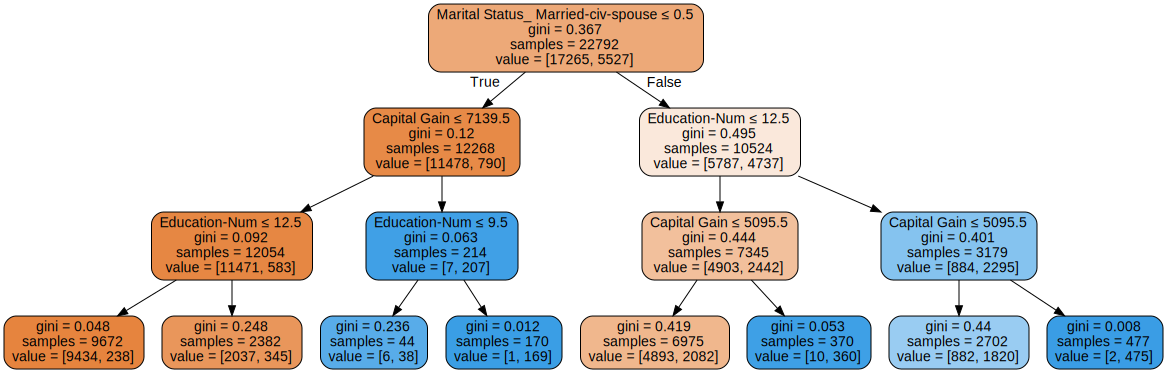

In [122]:
dot_data = tree.export_graphviz(clf,
                                feature_names =  X_tree_test.columns,
                                filled = True,
                                rounded = True,  
                                special_characters = True ) 
graph = graphviz.Source(dot_data, format="png") 
graph

# Train a Random Forest model on our data

In [117]:
def process_forest(df):
  df = df.copy()
  categorical_variables = ['Workclass', 'Marital Status', 'Occupation', 
                           'Relationship', 'Race', 'Sex', 'Country'] 
  for variable in categorical_variables:
    df[variable] = df[variable].cat.codes
  return df

In [118]:
X_forest_train = process_forest(X_train)
regr = RandomForestClassifier(max_depth=15, random_state=0, n_jobs=-1, n_estimators=50)
regr.fit(X_forest_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [119]:
X_forest_test = process_forest(X_test)
regr.score(X_forest_test, y_test)

0.8667212611321528

# Intrerpretability

## SHAP (SHapley Additive exPlanations)

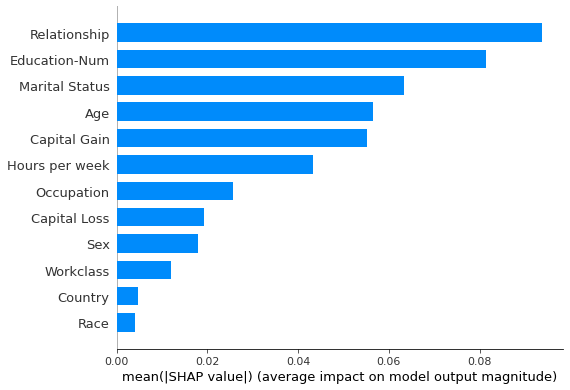

In [65]:
explainer = shap.Explainer(regr)
shap_values = explainer.shap_values(X_forest_test, approximate=True)
shap.summary_plot(shap_values[0], X_forest_test, plot_type="bar")

In [84]:
def show_waterfall(row = 0):
  print(eda_df.iloc[row])
  shap.waterfall_plot(
       shap.Explanation(values=shap_values[1][row], 
                        base_values=explainer.expected_value[1],
                        feature_names=X_forest_test.columns)
       )


Age                                37
Workclass                     Private
Education-Num                      10
Marital Status     Married-civ-spouse
Occupation            Exec-managerial
Relationship                  Husband
Race                            Black
Sex                              Male
Capital Gain                        0
Capital Loss                        0
Hours per week                     80
Country                 United-States
target                           True
Name: 10, dtype: object


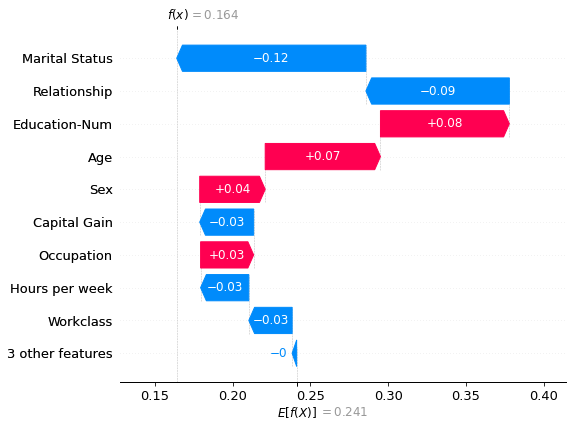

In [86]:
show_waterfall(10)

## Partial Dependance Plots

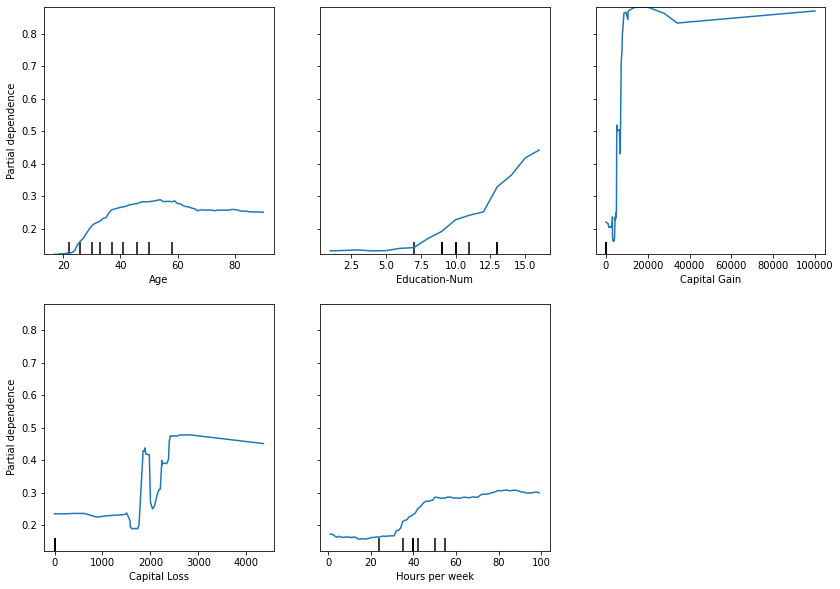

In [102]:
fig, ax = plt.subplots(figsize=(14, 10))
disp2 = plot_partial_dependence(regr, X_forest_test, [0, 2, 8, 9, 10], n_jobs=-1, ax=ax)  